# 1. CONFIGURAÇÃO DO AMBIENTE E ANÁLISE DA VARIÁVEL ALVO

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv('train.csv')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

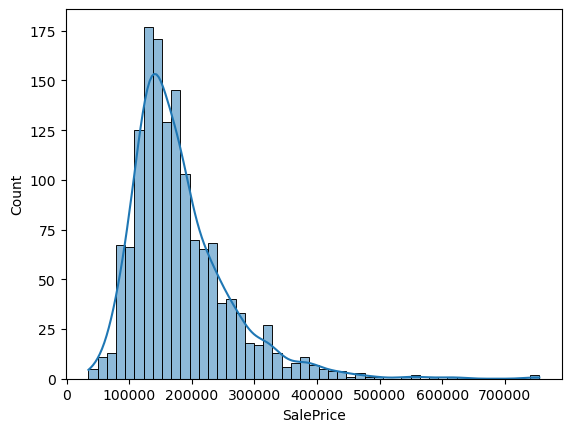

In [5]:
sns.histplot(train_df['SalePrice'], kde=True)
plt.show()

# 2. ANÁLISE DE CORRELAÇÃO E SELEÇÃO DE FEATURES

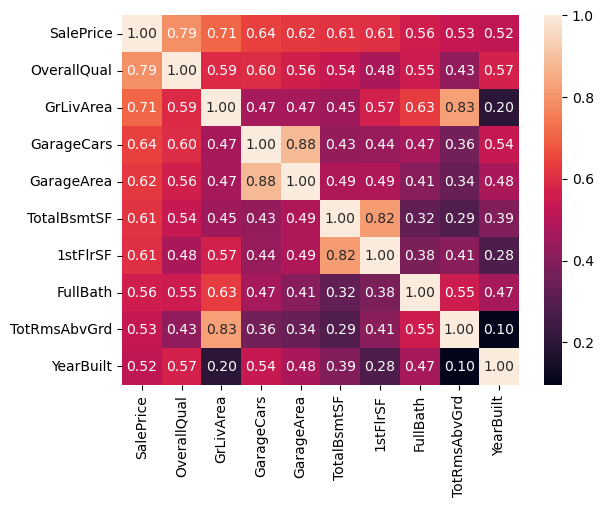

In [6]:
corr = train_df.corr(numeric_only=True)
k = 10
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
sns.heatmap(train_df[cols].corr(), annot=True, fmt='.2f')
plt.show()

# 3. Visualizando Relações e Identificando Outliers

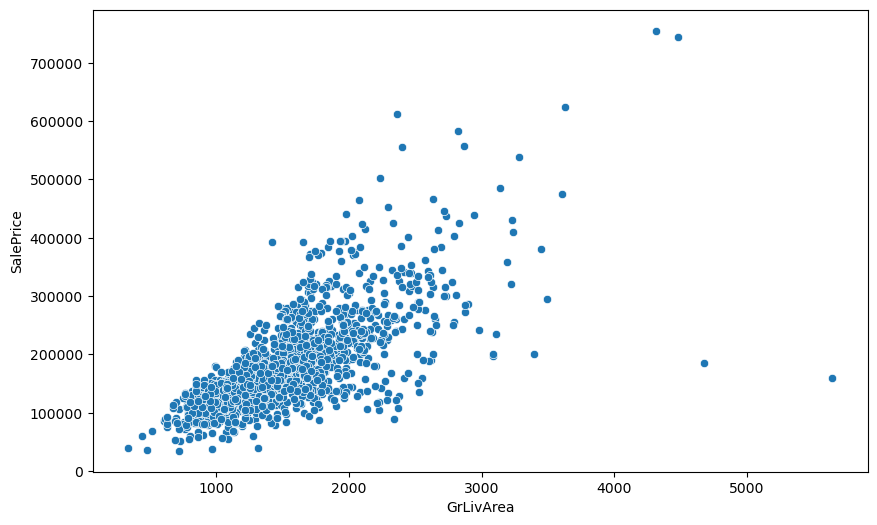

In [7]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_df['GrLivArea'], y=train_df['SalePrice'])
plt.show()

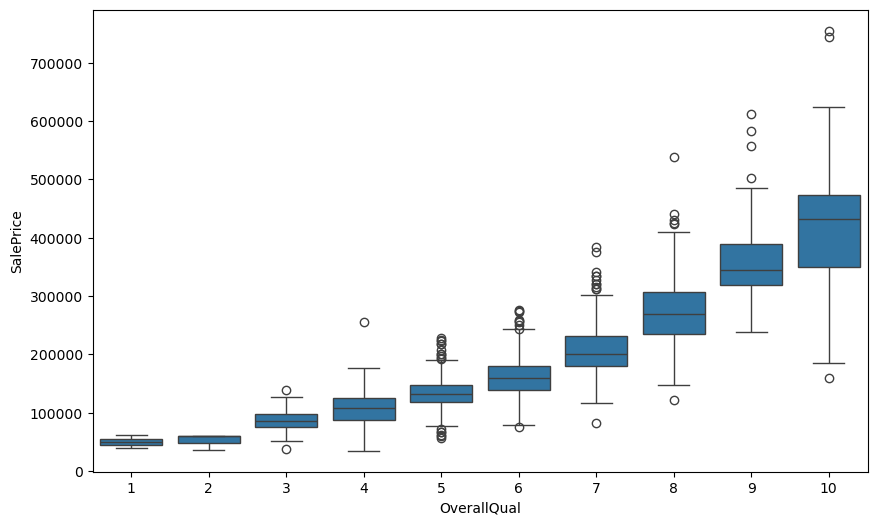

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_df['OverallQual'], y=train_df['SalePrice'])
plt.show()

# 4. Limpeza de Dados: Removendo Outliers

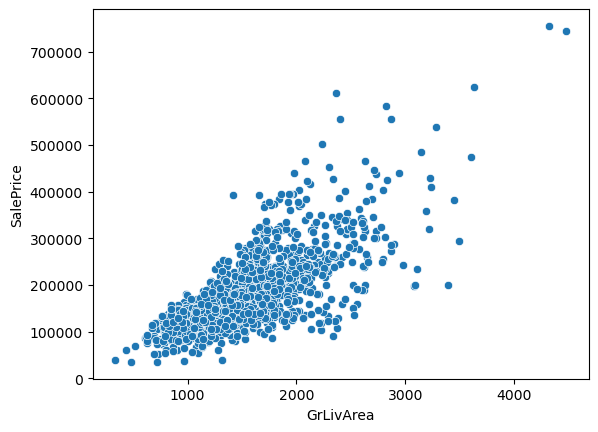

In [9]:
outliers = train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 300000)].index
train_df = train_df.drop(outliers)
sns.scatterplot(x=train_df['GrLivArea'], y=train_df['SalePrice'])
plt.show()

# 5. Tratamento da Variável Alvo: Log Transformation

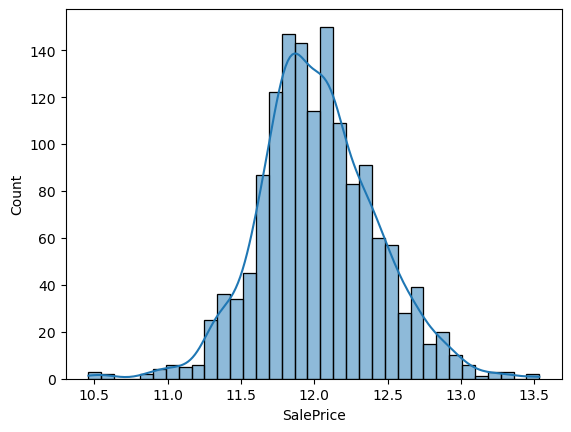

In [10]:
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])
sns.histplot(train_df['SalePrice'], kde=True)
plt.show()

# 6. Engenharia de Dados: Unificando Datasets

In [11]:
test_dt = pd.read_csv('test.csv')
ntrain = train_df.shape[0]
y_train = train_df['SalePrice'].values
all_data = pd.concat((train_df, test_dt)).reset_index(drop=True)
all_data = all_data.drop(['SalePrice'], axis=1)

In [12]:
all_data.shape

(2917, 80)

# 7. Análise de Dados Faltantes (Missing Values)

In [13]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]

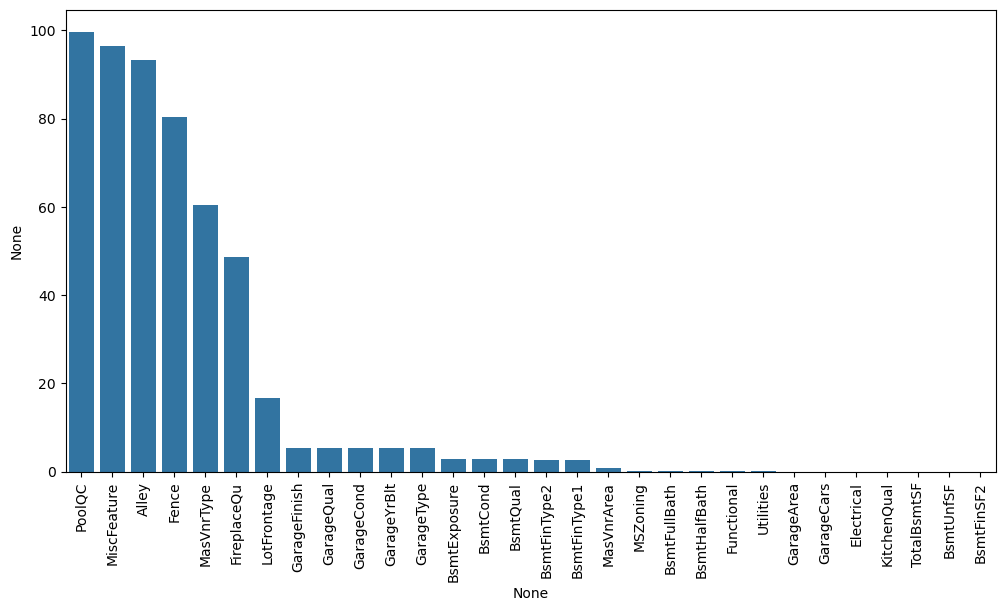

In [14]:
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
plt.figure(figsize=(12, 6)); sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xticks(rotation=90)
plt.show()

# 8. Imputação de Dados: Preenchendo os Nulos

In [15]:
# Lista de colunas onde NA significa 'Não possui'
cols_fill_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
                  'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                  'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                  'MasVnrType', 'MasVnrArea']

for col in cols_fill_none:
    all_data[col] = all_data[col].fillna("None")

In [16]:
# Lista de colunas onde NA significa 0
cols_fill_zero = ['GarageYrBlt', 'GarageArea', 'GarageCars',
                  'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF',
                  'BsmtFullBath', 'BsmtHalfBath']

for col in cols_fill_zero:
    all_data[col] = all_data[col].fillna(0)

In [17]:
# Preenche a frente do lote com a mediana do bairro
all_data['LotFrontage'] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [18]:
# Preenche com o valor mais comum (mode)
cols_fill_mode = ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional']

for col in cols_fill_mode:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [19]:
all_data = all_data.drop(['Utilities'], axis=1)

In [20]:
all_data.isnull().sum().max()

0

# 9. Feature Engineering: Criando Novas Variáveis

In [21]:
# MSSubClass = Classe da construção (é um código, não quantidade)
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

# OverallCond = Condição geral (vamos tratar como categoria para dar flexibilidade)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

# YrSold e MoSold = Ano e Mês (são temporais/categóricos, não quantidades contínuas)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [22]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# 10. Preparação Final: Dummy Variables e Separação

In [23]:
all_data = pd.get_dummies(all_data)

In [24]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [25]:
train.shape

(1458, 781)

# 11. Modelagem: Configuração de Validação Cruzada (Cross-Validation)

In [26]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [27]:
# Configuração da validação: 5 divisões, embaralhando os dados
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

# 12. Treinando Modelos Base: Lasso e XGBoost

In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

In [29]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [30]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=1.7817, n_estimators=2200,
                             random_state=7, nthread=-1)

In [31]:
score_lasso = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score_lasso.mean(), score_lasso.std()))

score_xgb = rmsle_cv(model_xgb)
print("XGBoost score: {:.4f} ({:.4f})\n".format(score_xgb.mean(), score_xgb.std()))


Lasso score: 0.1119 (0.0060)

XGBoost score: 0.1203 (0.0067)



# 13. Previsão Final e Submissão

In [32]:
lasso.fit(train, y_train)
model_xgb.fit(train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4603, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.0468, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=1.7817, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2200,
             n_jobs=None, nthread=-1, ...)

In [33]:
xgb_pred = np.expm1(model_xgb.predict(test))
lasso_pred = np.expm1(lasso.predict(test))

In [34]:
# 70% Lasso, 30% XGBoost
final_pred = (0.7 * lasso_pred) + (0.3 * xgb_pred)

In [35]:
test_original = pd.read_csv('test.csv') # Lendo só pra pegar os IDs

submission = pd.DataFrame()
submission['Id'] = test_original['Id']
submission['SalePrice'] = final_pred

submission.to_csv('submission_ensemble.csv', index=False)

# 14. Resultados Finais: Visualização das Previsões

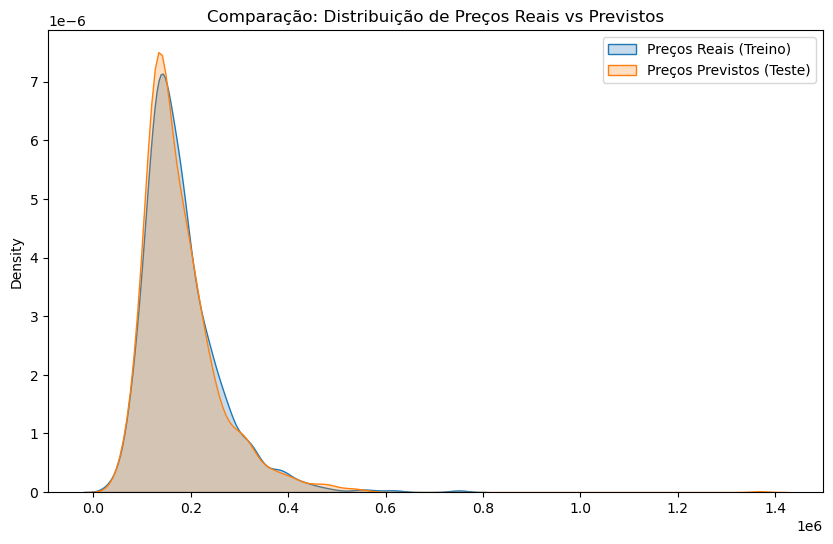

In [36]:
# Comparação Visual: Realidade vs Previsão
plt.figure(figsize=(10,6))
sns.kdeplot(np.expm1(y_train), label='Preços Reais (Treino)', fill=True)
sns.kdeplot(final_pred, label='Preços Previstos (Teste)', fill=True)
plt.legend()
plt.title("Comparação: Distribuição de Preços Reais vs Previstos")
plt.show()

# 🏁 Conclusão do Projeto: Precificação Inteligente de Imóveis

## 🎯 Objetivo
Desenvolver um modelo preditivo robusto para estimar preços de venda de imóveis com base em mais de 80 características físicas e de localização, simulando um cenário real de uma PropTech.

## ⚙️ Metodologia Aplicada

### 1. Análise Exploratória e Estatística (EDA)
*   Identificamos que a variável alvo (`SalePrice`) possuía **Assimetria Positiva** (cauda longa).
*   Solução: Aplicamos transformação **Logarítmica (`log1p`)** para normalizar a distribuição e melhorar a performance dos modelos lineares.
*   Análise de Correlação: Identificamos `OverallQual` (Qualidade Geral) e `GrLivArea` (Área Habitável) como os maiores influenciadores do preço.

### 2. Tratamento e Limpeza de Dados
*   **Remoção de Outliers:** Excluímos imóveis com área superior a 4000 pés² vendidos a preços anormalmente baixos, limpando o ruído para o modelo.
*   **Imputação Semântica:** Diferenciamos dados nulos:
    *   Para colunas como Piscina/Garagem: Nulo = "Não Possui" (Categoria) ou 0 (Numérico).
    *   Para `LotFrontage`: Imputação pela mediana da vizinhança.

### 3. Engenharia de Atributos (Feature Engineering)
*   **TotalSF:** Criação de uma variável unificada somando Porão + 1º Andar + 2º Andar, capturando a área real construída.
*   **Correção de Tipos:** Conversão de variáveis numéricas enganosas (como `MSSubClass`) para categóricas.
*   **Dummificação:** Transformação de todas as variáveis categóricas em vetores binários (One-Hot Encoding).

### 4. Modelagem Avançada (Ensemble)
Utilizamos uma abordagem híbrida para equilibrar *Bias* e *Variance*:
*   **LASSO (Least Absolute Shrinkage and Selection Operator):** Excelente para lidar com a alta dimensionalidade (700+ colunas) e descartar variáveis irrelevantes.
*   **XGBoost (Gradient Boosting):** Poderoso para capturar padrões não-lineares e interações complexas entre variáveis.

## 🏆 Resultado Final
O modelo final foi um **Ensemble Ponderado** (70% Lasso + 30% XGBoost).
A validação cruzada (K-Fold com 5 splits) apresentou um erro logarítmico (RMSLE) médio de **~0.11**, indicando alta precisão nas estimativas.